In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

def safe_array_divide(numerator, denominator):
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.true_divide(numerator, denominator)
        ratio = np.nan_to_num(ratio, nan=0, posinf=0, neginf=0)
    return ratio


In [2]:
training_vars = ['jet_pt', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['equal_weight']
filename = './clf.pkl'

sample_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/samples/sample_allpt_all_jets.pkl'
label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]


In [3]:
sample = pd.read_pickle(sample_path)

In [4]:
with open(filename, 'rb') as f:
    clf = pickle.load(f)

In [5]:
clf

GradientBoostingClassifier(max_depth=7, n_estimators=200, random_state=42,
                           validation_fraction=0.1111111111111111, verbose=1)

In [6]:
y_sample = clf.decision_function(sample[training_vars])
sample['new_GBDTscore'] = y_sample

In [7]:
sample.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target,new_GBDTscore
0,766.747925,1.298662,2.0,0.318292,0.215923,-0.192873,21.0,1.0,17.609434,2.703190e-05,1.0,1,1.0,0.312891
0,680.507996,0.447689,24.0,0.064352,0.208339,0.066904,2.0,1.0,0.331535,2.858433e-07,0.0,1,0.0,-0.150282
1,619.839111,0.588775,34.0,0.115656,0.298206,0.232268,21.0,1.0,0.331535,1.655248e-07,1.0,1,1.0,1.565108
2,721.692932,-0.716669,12.0,0.049718,0.220595,-0.169604,2.0,1.0,0.377624,3.935379e-07,0.0,1,0.0,-1.298601
3,697.332947,-1.042831,22.0,0.091199,0.278667,0.029374,21.0,1.0,0.377624,3.255802e-07,1.0,1,1.0,0.116745


In [8]:
sample.to_pickle('pred_sample.pkl')

In [9]:
sample = pd.read_pickle('pred_sample.pkl')

In [10]:
def Calculate_reweight_factor(sample, clf_type):
    assert clf_type in ['new_MLPprob', 'new_GBDTscore']

    if clf_type == 'new_MLPprob':
        clf_range = (0, 1) 
    if clf_type == 'new_GBDTscore':
        clf_range = (-5.0, 5.0) 

    features = [*sample.columns[:6]] + [clf_type] 
    HistBins = {
        features[0] : np.linspace(0, 2000, 61), 
        features[1] : np.linspace(-2.5, 2.5, 51),
        features[2] : np.linspace(0, 60, 61),
        features[3] : np.linspace(0, 0.4, 61), 
        features[4] : np.linspace(0, 0.4, 61), 
        features[5] : np.linspace(-1.0, 1.0, 51),
        clf_type : np.linspace(clf_range[0], clf_range[1], 51)
    }
    label_vars = ['jet_nTracks', 'jet_trackBDT', clf_type]

    # Initialize all the vars 
    for var in label_vars:
        sample[f'{var}_quark_reweighting_weights'] = sample['event_weight'].copy()
        sample[f'{var}_gluon_reweighting_weights'] = sample['event_weight'].copy()

    reweighted_sample = []
    reweight_factors = {}
    for pt_idx, pt in enumerate(tqdm(label_pt_bin[:-1])):
        reweight_factors[pt] = {}
        sample_pt = sample[sample['pt_idx'] == pt_idx]  # Get the pt slice 
        _sample = sample_pt
        
        forward_quark = _sample[(_sample['is_forward']==1) &(_sample['target']==0)]
        forward_gluon = _sample[(_sample['is_forward']==1) &(_sample['target']==1)]
        central_quark = _sample[(_sample['is_forward']==0) &(_sample['target']==0)]
        central_gluon = _sample[(_sample['is_forward']==0) &(_sample['target']==1)]

        for var in label_vars:
            bin_var = HistBins[var]
            hist_forward_quark, _ = np.histogram(forward_quark[var], bins=bin_var, weights=forward_quark['event_weight'])
            hist_central_quark, _ = np.histogram(central_quark[var], bins=bin_var, weights=central_quark['event_weight'])
            hist_forward_gluon, _ = np.histogram(forward_gluon[var], bins=bin_var, weights=forward_gluon['event_weight'])
            hist_central_gluon, _ = np.histogram(central_gluon[var], bins=bin_var, weights=central_gluon['event_weight'])

            quark_factor = safe_array_divide(numerator=hist_forward_quark, denominator=hist_central_quark)
            gluon_factor = safe_array_divide(numerator=hist_forward_gluon, denominator=hist_central_gluon)
            reweight_factors[pt][f'{var}_quark_factor'] = quark_factor
            reweight_factors[pt][f'{var}_gluon_factor'] = gluon_factor

            new_var_idx = pd.cut(_sample[var], bins=bin_var, right=False, labels=False)  # Binned feature distribution 
            for i, score in enumerate(bin_var[:-1]): # Loop over the bins 
                mod_idx = np.where(new_var_idx == i)[0]
                _sample.iloc[mod_idx, _sample.columns.get_loc(f'{var}_quark_reweighting_weights')] *= quark_factor[i]
                _sample.iloc[mod_idx, _sample.columns.get_loc(f'{var}_gluon_reweighting_weights')] *= gluon_factor[i]
            
        reweighted_sample.append(_sample)

    return pd.concat(reweighted_sample), reweight_factors




In [11]:
reweighted_sample, reweight_factors = Calculate_reweight_factor(sample=sample, clf_type='new_GBDTscore')

100%|██████████| 6/6 [00:53<00:00,  8.96s/it]


In [12]:
reweighted_sample.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,pt_idx,target,new_GBDTscore,jet_nTracks_quark_reweighting_weights,jet_nTracks_gluon_reweighting_weights,jet_trackBDT_quark_reweighting_weights,jet_trackBDT_gluon_reweighting_weights,new_GBDTscore_quark_reweighting_weights,new_GBDTscore_gluon_reweighting_weights
7,525.046448,-1.230899,21.0,0.026432,0.188511,0.136256,1.0,1.0,0.502558,1.737371e-07,1.0,0,0.0,0.738581,0.736131,0.377296,0.699280,0.378954,0.738505,0.376232
11,519.972595,-1.157604,17.0,0.120245,0.257995,-0.025059,21.0,1.0,1.053274,3.573635e-07,1.0,0,1.0,-0.082180,1.476486,0.749412,1.340951,0.754682,1.373013,0.746853
15,533.982361,-1.150206,11.0,0.015249,0.185861,-0.274700,2.0,1.0,0.698572,2.415003e-07,1.0,0,0.0,-1.636862,0.852193,0.469778,0.886139,0.506668,0.862221,0.479409
17,534.412231,-0.183188,40.0,0.198334,0.333095,0.310029,21.0,1.0,0.394101,1.362431e-07,0.0,0,1.0,1.862871,0.632219,0.347629,0.593279,0.312994,0.657138,0.325882
18,503.886597,0.486479,40.0,0.086191,0.283057,0.412483,21.0,1.0,1.292122,4.384019e-07,1.0,0,1.0,2.434734,2.072829,1.139754,1.934260,1.014520,2.388956,1.164452


In [13]:
reweighted_sample.to_pickle('reweighted_pred_sample.pkl')

In [14]:
with open('./reweight_factors.pkl', 'wb') as f:
    pickle.dump(reweight_factors, f)

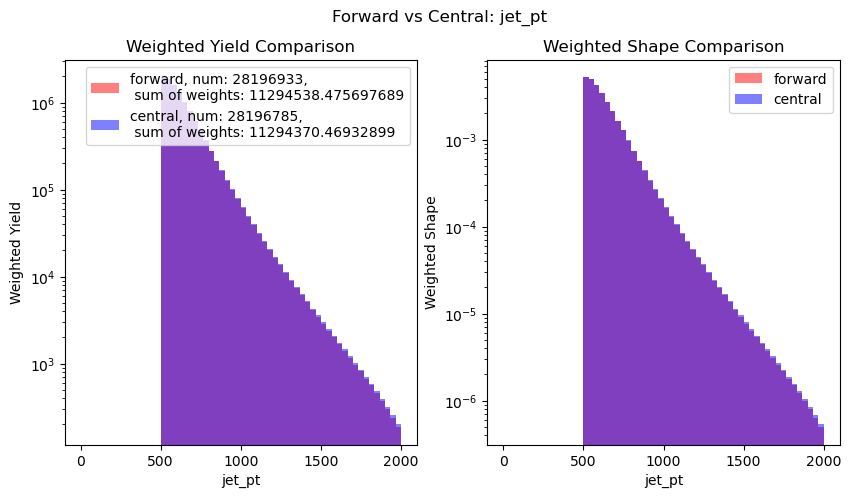

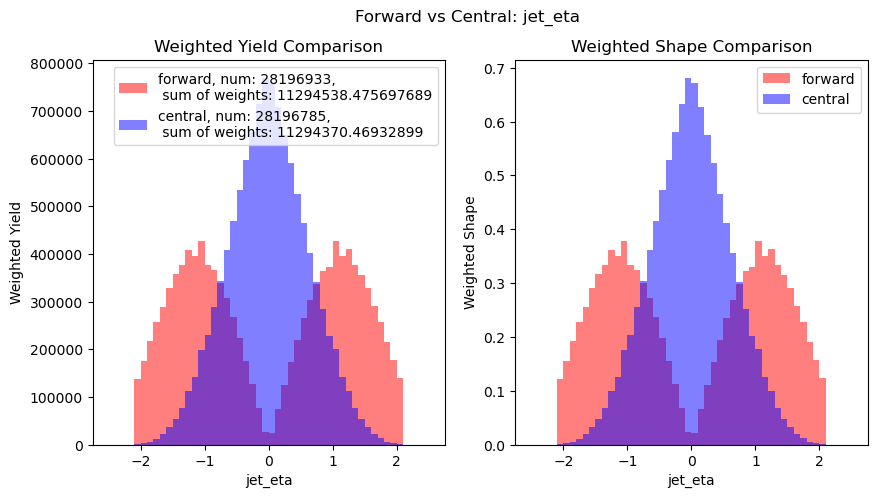

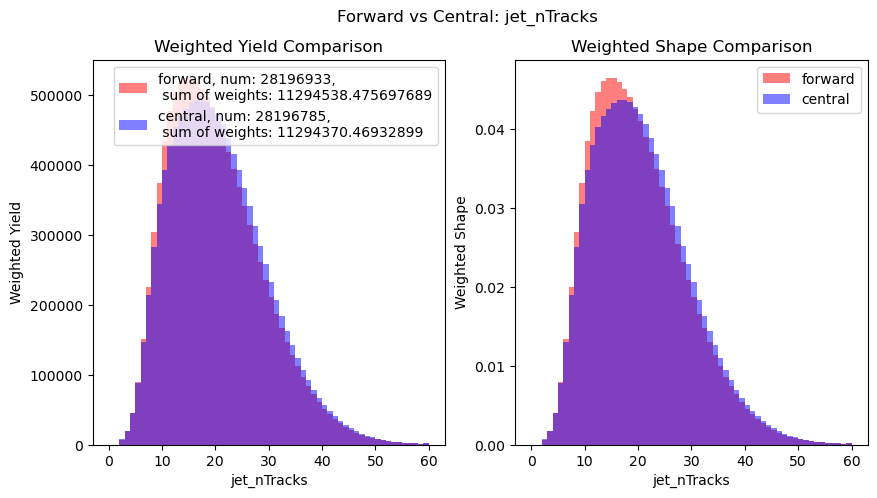

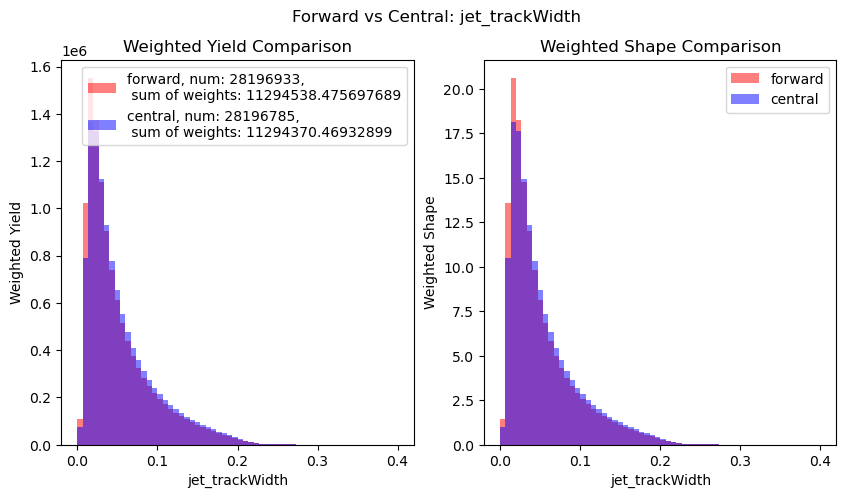

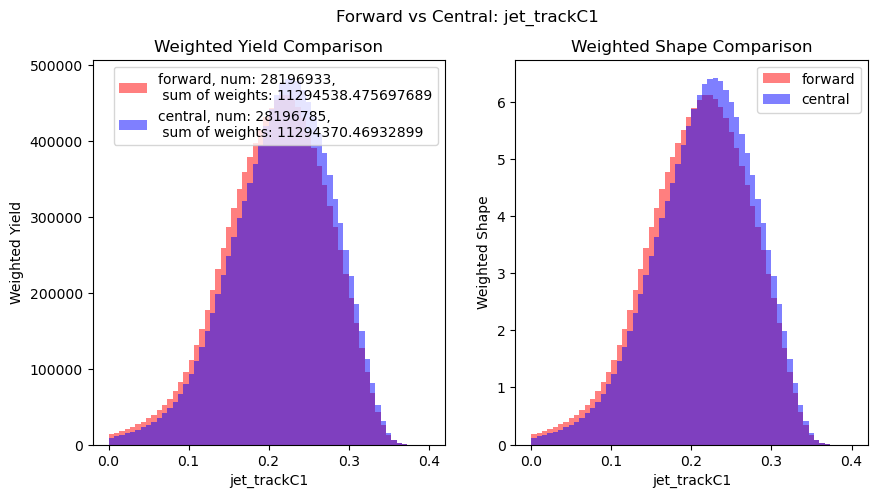

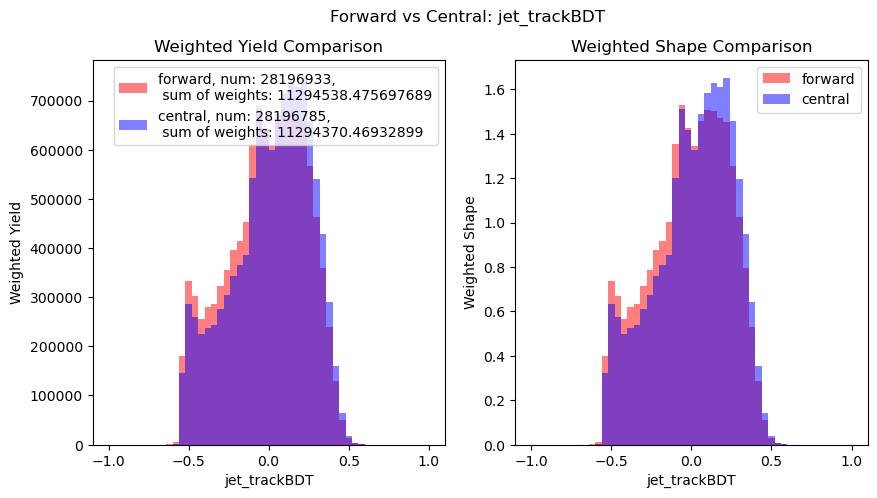

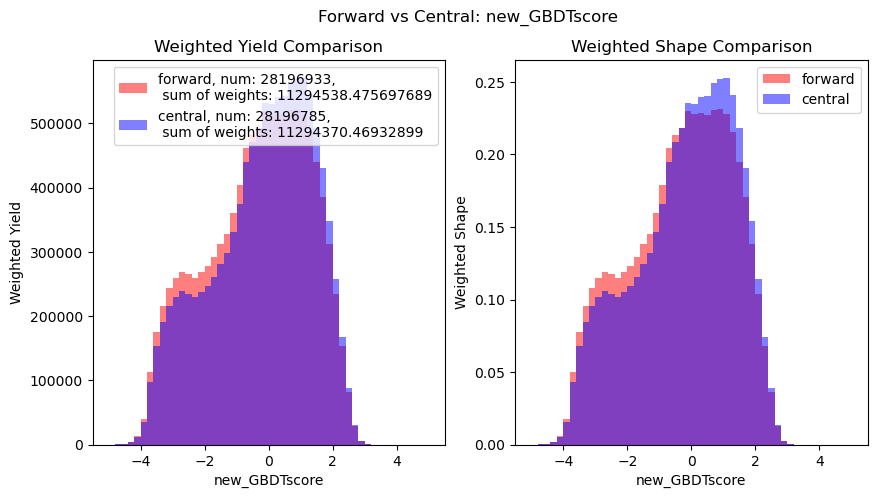

In [18]:
features = [*sample.columns[:6]] + ['new_GBDTscore'] 
HistBins = {
    features[0] : np.linspace(0, 2000, 61), 
    features[1] : np.linspace(-2.5, 2.5, 51),
    features[2] : np.linspace(0, 60, 61),
    features[3] : np.linspace(0, 0.4, 61), 
    features[4] : np.linspace(0, 0.4, 61), 
    features[5] : np.linspace(-1.0, 1.0, 51), 
    features[6] : np.linspace(-5, 5.0, 51),
}

sample_forward = sample[sample['is_forward']==1]
sample_central = sample[sample['is_forward']==0]

for feature_name in features:
    custom_bins = HistBins[feature_name]
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
    ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], 
            label = f'forward, num: {len(sample_forward)},\n sum of weights: {np.sum(sample_forward["event_weight"]):.2f}', 
            color='red', alpha = 0.5)
    ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], 
            label = f'central, num: {len(sample_central)},\n sum of weights: {np.sum(sample_central["event_weight"]):.2f}', 
            color='blue', alpha = 0.5)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Yield")
    ax0.set_title(f"Weighted Yield Comparison")

    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
    ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'central', color='blue', alpha = 0.5, density=True)
    ax1.legend()
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel(f"Weighted Shape")
    ax1.set_title(f"Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax1.set_yscale('log')
    fig.suptitle(f"Forward vs Central: {feature_name}")

    plt.plot()
    

Text(0.5, 0.98, 'new_GBDTscore')

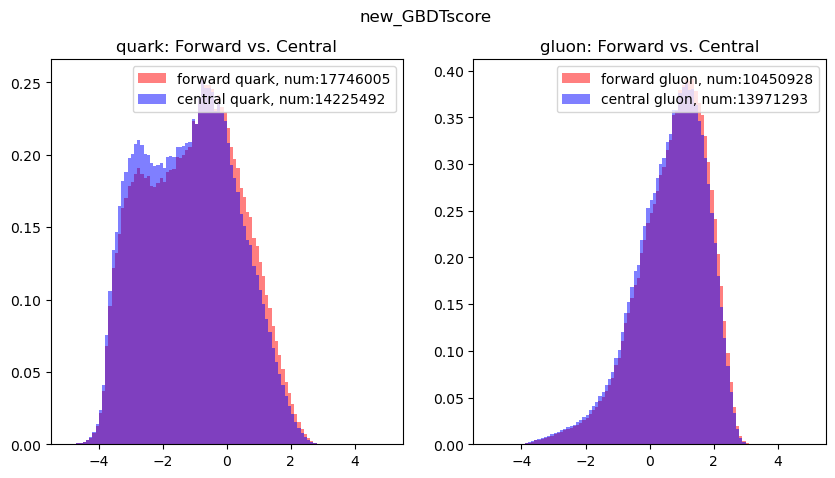

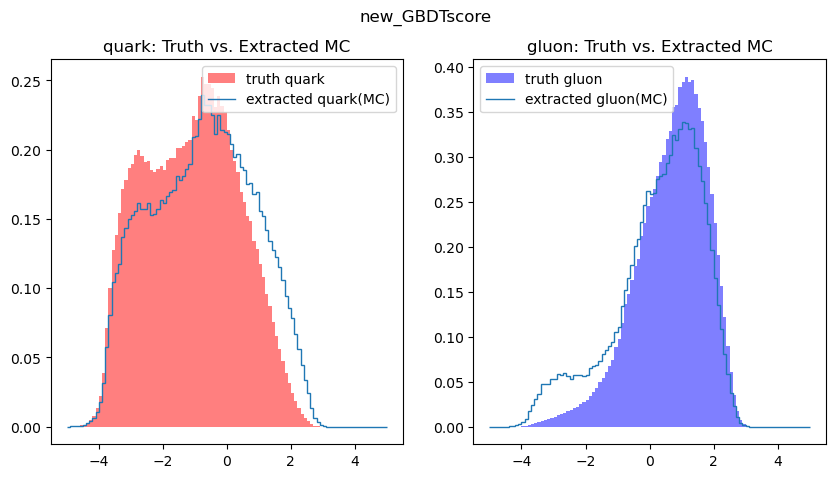

In [19]:
forward_quark = sample[(sample['is_forward']==1) &(sample['target']==0)]
forward_gluon = sample[(sample['is_forward']==1) &(sample['target']==1)]
central_quark = sample[(sample['is_forward']==0) &(sample['target']==0)]
central_gluon = sample[(sample['is_forward']==0) &(sample['target']==1)]
forward = sample[(sample['is_forward']==1)]
central = sample[(sample['is_forward']==0)]
quark = sample[sample['target']==0]
gluon = sample[sample['target']==1]

newbdt_bins = np.linspace(-5, 5, 101)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
feature = 'new_GBDTscore'
ax[0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
          label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
ax[0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
          label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
ax[0].legend()
ax[0].set_title('quark: Forward vs. Central')

ax[1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
          label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
ax[1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
          label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
ax[1].set_title('gluon: Forward vs. Central')
ax[1].legend()
fig.suptitle(feature)


n_forward_quark = np.sum(forward_quark['event_weight'])
n_central_quark = np.sum(central_quark['event_weight'])
n_forward = np.sum(forward['event_weight'])
n_central = np.sum(central['event_weight'])

frac_forward_quark = n_forward_quark / n_forward
frac_central_quark = n_central_quark / n_central

frac_forward_gluon = 1 - frac_forward_quark
frac_central_gluon = 1 - frac_central_quark

f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
f_inv = np.linalg.inv(f)


# Do a simple extraction test
# MC closure 
hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)


extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
          label=f'truth quark', color='red', alpha = 0.5, density=True)
ax[0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
ax[0].legend()
ax[0].set_title('quark: Truth vs. Extracted MC')

ax[1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
          label=f'truth gluon', color='blue', alpha = 0.5, density=True)
ax[1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
ax[1].legend()
ax[1].set_title('gluon: Truth vs. Extracted MC')

fig.suptitle(feature)


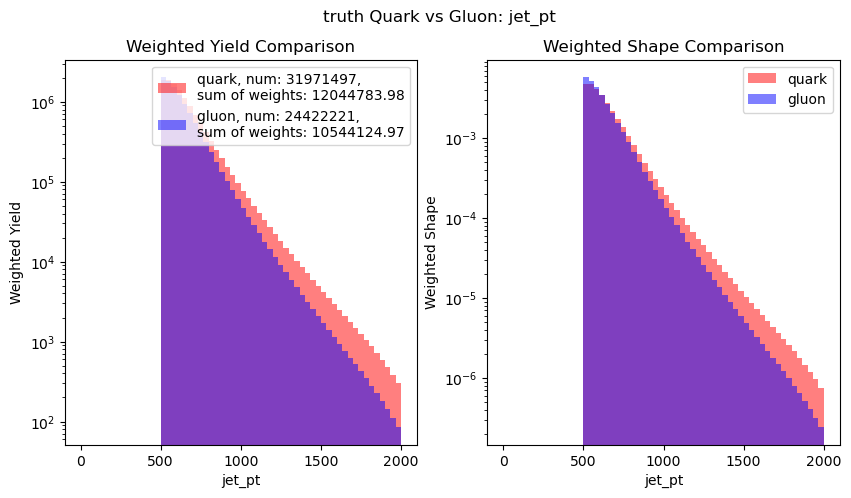

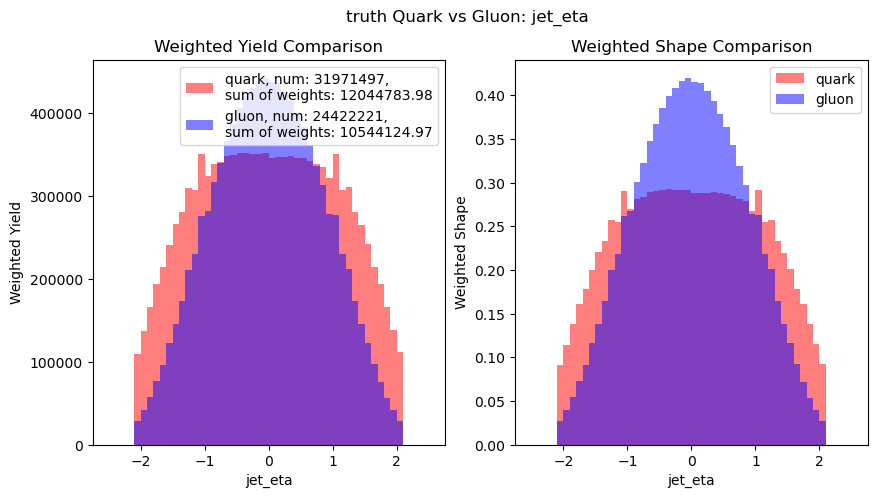

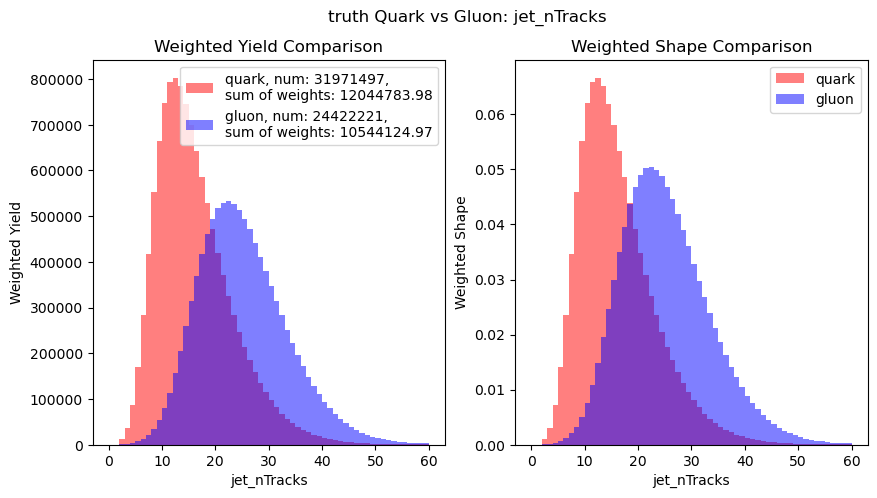

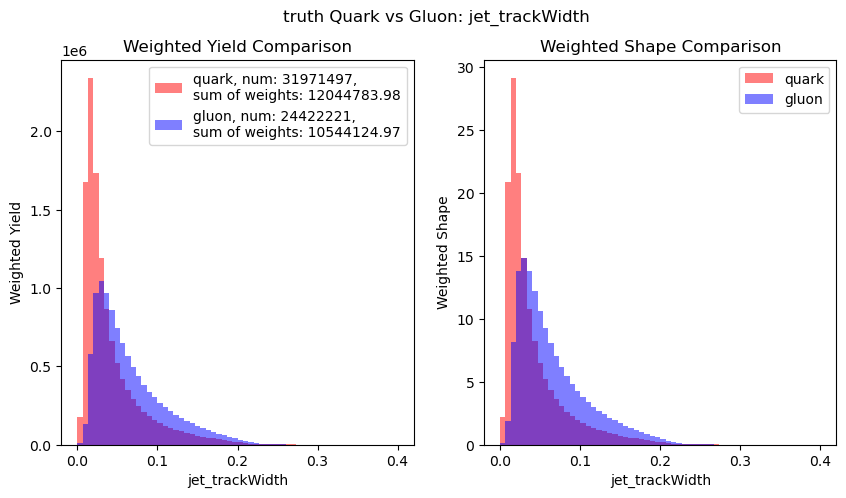

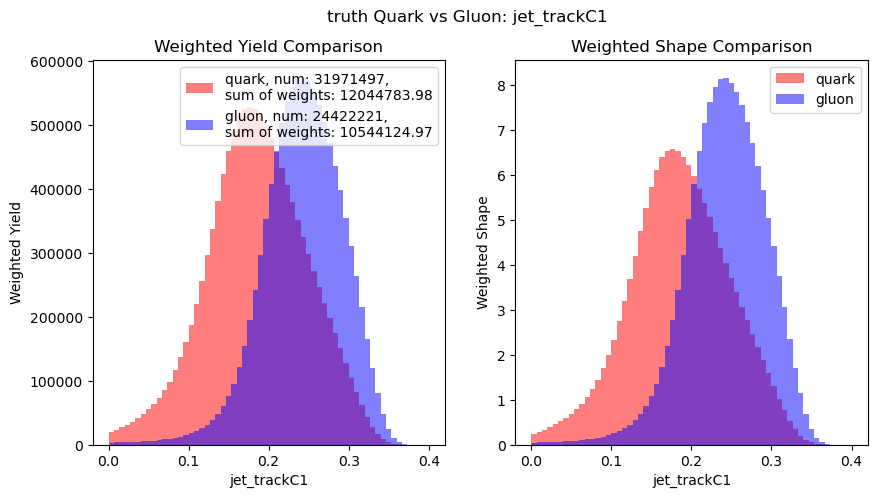

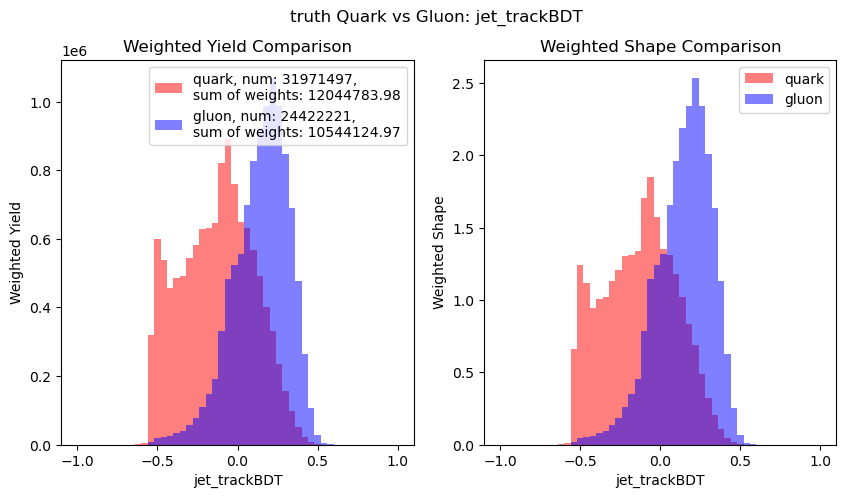

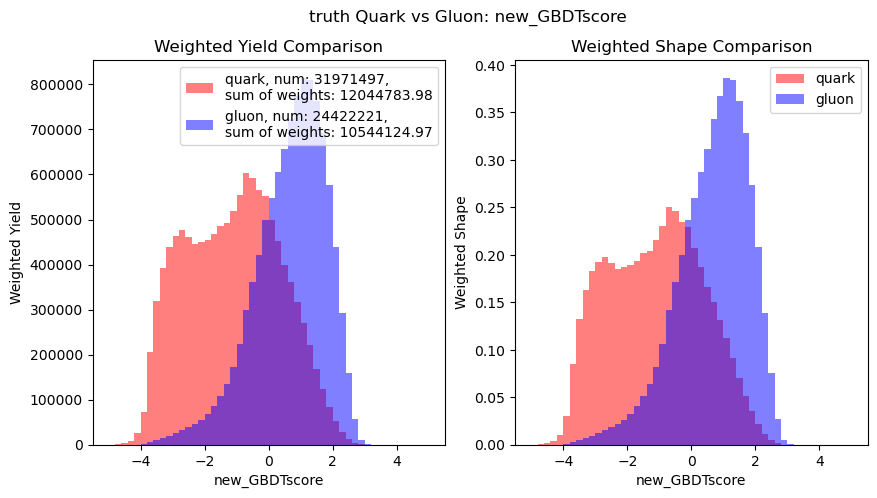

In [22]:
for feature_name in features:
    custom_bins = HistBins[feature_name]
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
    ax0.hist(quark[feature_name], bins = custom_bins, weights = quark['event_weight'], 
            label = f'quark, num: {len(quark)},\nsum of weights: {np.sum(quark["event_weight"]):.2f}', 
            color='red', alpha = 0.5)
    ax0.hist(gluon[feature_name], bins = custom_bins, weights = gluon['event_weight'], 
            label = f'gluon, num: {len(gluon)},\nsum of weights: {np.sum(gluon["event_weight"]):.2f}', 
            color='blue', alpha = 0.5)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Yield")
    ax0.set_title(f"Weighted Yield Comparison")

    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    ax1.hist(quark[feature_name], bins = custom_bins, weights = quark['event_weight'], label = 'quark', color='red', alpha = 0.5, density=True)
    ax1.hist(gluon[feature_name], bins = custom_bins, weights = gluon['event_weight'], label = 'gluon', color='blue', alpha = 0.5, density=True)
    ax1.legend()
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel(f"Weighted Shape")
    ax1.set_title(f"Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax1.set_yscale('log')
    fig.suptitle(f"truth Quark vs Gluon: {feature_name}")

    plt.plot()
    

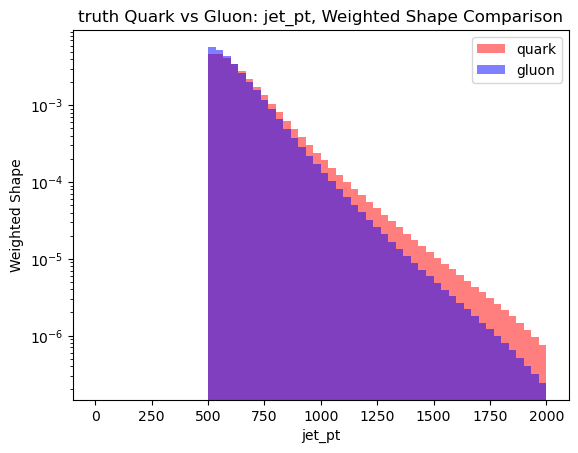

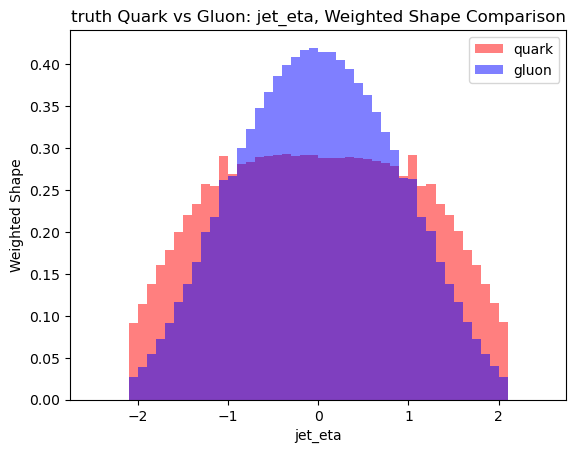

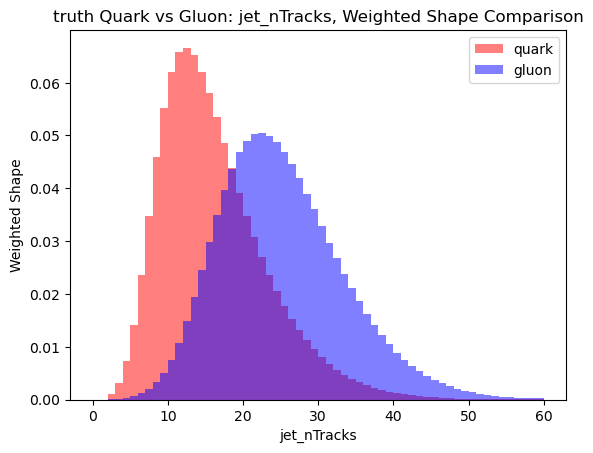

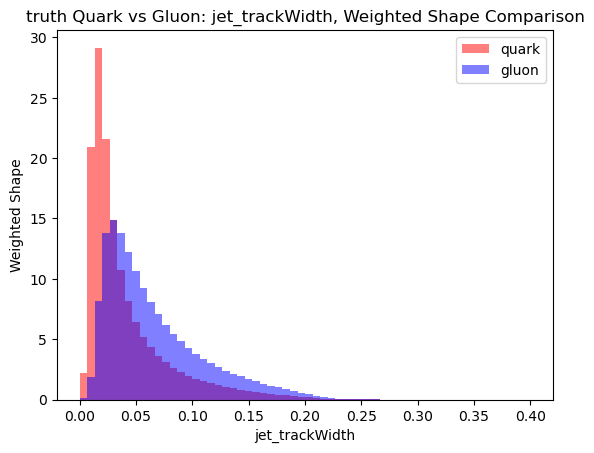

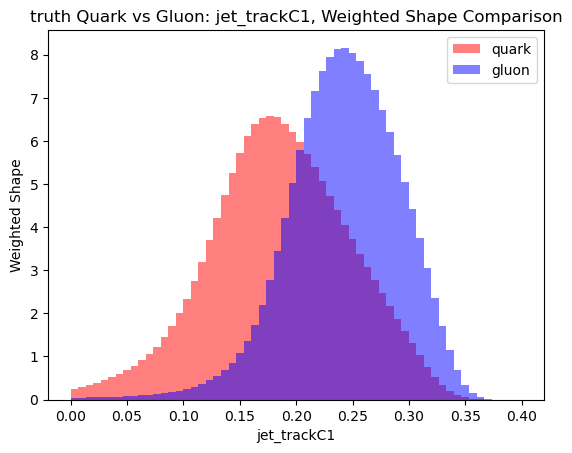

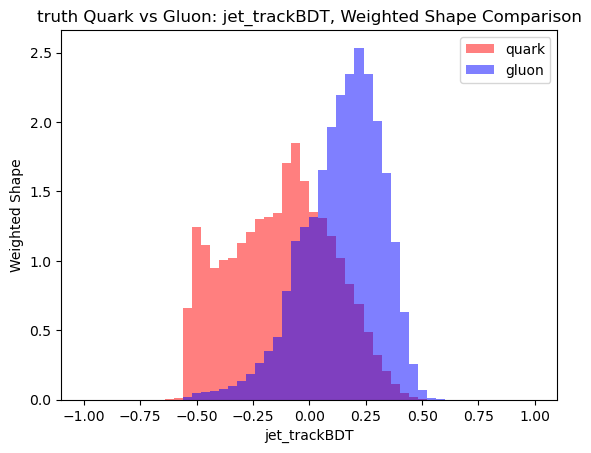

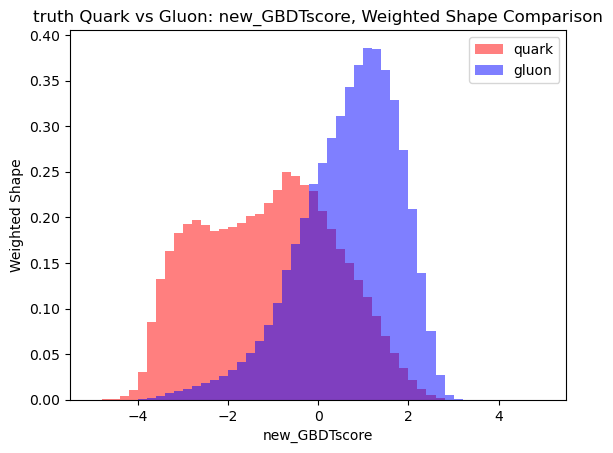

In [23]:
for feature_name in features:
    custom_bins = HistBins[feature_name]
    fig, ax0 = plt.subplots()

    ax0.hist(quark[feature_name], bins = custom_bins, weights = quark['event_weight'], label = 'quark', color='red', alpha = 0.5, density=True)
    ax0.hist(gluon[feature_name], bins = custom_bins, weights = gluon['event_weight'], label = 'gluon', color='blue', alpha = 0.5, density=True)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Shape")
    ax0.set_title(f"truth Quark vs Gluon: {feature_name}, Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    plt.plot()
    